## WGAN-PG with MNIST

## model

In [38]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

import matplotlib.pyplot as plt

In [39]:
class hyperparameters:
  n_epochs = 50
  img_size = 28
  batch_size = 128
  lr = 0.0002
  b1 = 0.5
  b2 = 0.999
  latent_dim = 100
  channels = 1
  n_critic = 5
  clip_value = 0.1
  sample_interval = 400

opt = hyperparameters()

lambda_gp = 10

img_shape = (opt.channels, opt.img_size, opt.img_size)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

### pare GPU

In [40]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
!nvidia-smi

cuda = True if torch.cuda.is_available() else False

True
1
Thu Mar  2 09:16:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |    861MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

### datasets

torch.Size([1, 28, 28])
5


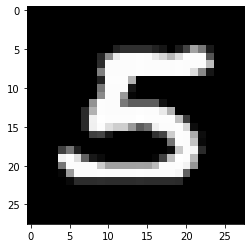

In [41]:
dataloader = torch.utils.data.DataLoader(
    dataset=datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# show a example data
index = 10

dataiter = iter(dataloader)
(img, label) = next(dataiter)

print(img[0].shape)
print(label[index].item())

plt.imshow(img[index].squeeze(), cmap='gray')

## define hyperparameter

In [42]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [43]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [44]:
Generator_PATH = './Gmodel'
Discriminator_PATH = './Dmodel'

# generator.load_state_dict(torch.load(Generator_PATH))
# discriminator.load_state_dict(torch.load(Discriminator_PATH))

In [45]:
batches_done = 0
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            # if batches_done % opt.sample_interval == 0:
            #     save_image(fake_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += opt.n_critic
    if epoch % 10 == 0:
      print(
          "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
      )


torch.save(generator.state_dict(), Generator_PATH)
torch.save(discriminator.state_dict(), Discriminator_PATH)

[Epoch 0/50] [Batch 468/469] [D loss: -2.191112] [G loss: -6.843139]
[Epoch 10/50] [Batch 468/469] [D loss: -4.964634] [G loss: 3.039547]
[Epoch 20/50] [Batch 468/469] [D loss: -3.475343] [G loss: 0.117437]
[Epoch 30/50] [Batch 468/469] [D loss: -3.030369] [G loss: -0.396256]
[Epoch 40/50] [Batch 468/469] [D loss: -2.271953] [G loss: -0.974345]


In [ ]:
torch.save(generator.state_dict(), Generator_PATH)
torch.save(discriminator.state_dict(), Discriminator_PATH)

## test

torch.Size([1, 28, 28])


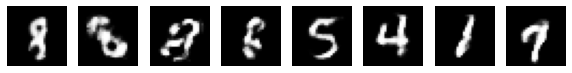

In [47]:
with torch.no_grad():
  # Sample noise as generator input
  z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

  # Generate a batch of images
  gen_imgs = generator(z)
  gen_imgs = gen_imgs.cpu()

  print(gen_imgs[0].shape)

  fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(10,5))

  for i, ax in enumerate(axes):
      ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
      ax.axis('off')
